<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

In [2]:
# import zipfile
# with zipfile.ZipFile('Positive_tensors.zip', 'r') as zip_ref:
#     zip_ref.extractall()

In [3]:
# ! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip


In [4]:
# import zipfile
# with zipfile.ZipFile('Negative_tensors.zip', 'r') as zip_ref:
#     zip_ref.extractall()

We will install torchvision:


In [5]:
# %pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [6]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [7]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [8]:
# Create your own dataset object
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True): # Initialize the Dataset class with optional transform and train flag.
        directory="." # Define the base directory.
        positive="Positive_tensors" # Define the subdirectory for positive samples.
        negative='Negative_tensors' # Define the subdirectory for negative samples.

        positive_file_path=os.path.join(directory,positive) # Create the full path for positive samples.
        negative_file_path=os.path.join(directory,negative) # Create the full path for negative samples.
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")] # Get a list of all .pt files in the positive samples directory.
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")] # Get a list of all .pt files in the negative samples directory.
        number_of_samples=len(positive_files)+len(negative_files) # Calculate the total number of samples.
        self.all_files=[None]*number_of_samples # Initialize a list to hold all file paths, pre-allocate to improve efficiency.
        self.all_files[::2]=positive_files # Assign positive file paths to even indices.
        self.all_files[1::2]=negative_files # Assign negative file paths to odd indices.

        # The transform is going to be used on image
        self.transform = transform # Store the provided transform.

        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor) # Initialize a tensor to store labels (0 for negative, 1 for positive).
        self.Y[::2]=1 # Assign label 1 to even indices (positive samples).
        self.Y[1::2]=0 # Assign label 0 to odd indices (negative samples).
        

        # Split data into training and testing sets if train is True.
        if train:
            self.all_files=self.all_files[0:30000] # Use the first 30000 samples for training.
            self.Y=self.Y[0:30000] # Use the first 30000 labels for training.
            self.len=len(self.all_files) # Set the length of the dataset for training.
        else:
            self.all_files=self.all_files[30000:] # Use the remaining samples for testing.
            self.Y=self.Y[30000:] # Use the remaining labels for testing.
            self.len=len(self.all_files) # Set the length of the dataset for testing.
       
    # Get the length
    def __len__(self): # Return the length of the dataset.
        return self.len # Return the length of the dataset.
    
    # Getter
    def __getitem__(self, idx): # Get a single data sample.
               
        image=torch.load(self.all_files[idx]) # Load the image from the specified file path.
        y=self.Y[idx] # Get the corresponding label.
                  
        # If there is any transform method, apply it onto the image
        if self.transform: # Apply the transform if one was provided.
            image = self.transform(image) # Apply the transform to the image.

        return image, y # Return the image and its label.
    
print("done")


done


We create two dataset objects, one for the training data and one for the validation data.


In [33]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")
print("train_dataset: ", len(train_dataset))
print("validation_dataset: ", len(validation_dataset))

done
train_dataset:  30000
validation_dataset:  10000


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [10]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model = models.resnet18(pretrained=True)


c:\Users\admin\Development\IBM Deep Learning with PyTorch, Keras and Tensorflow\.conda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\Development\IBM Deep Learning with PyTorch, Keras and Tensorflow\.conda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model


# Type your code here

# Freeze the model's parameters to prevent them from being updated during training:
for param in model.parameters():
    param.requires_grad = False

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [13]:
num_ftrs = model.fc.in_features
num_out_classes = 2
model.fc = torch.nn.Linear(num_ftrs, num_out_classes)


Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [15]:
# Step 1: Create the loss function

# Type your code here

criterion = nn.CrossEntropyLoss()


<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [36]:
train_loader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=100)
print(len(train_loader))
print(len(validation_loader))

300
100


<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [17]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [18]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    loss_sublist = []
    for x, y in train_loader:
        model.train()
        optimizer.zero_grad() #clear gradient
        yhat = model(x) #make a prediction
        loss = criterion(yhat, y) # calculate loss
        loss_sublist.append(loss.data.item())
        loss.backward() # calculate gradients of parameters
        optimizer.step() # update parameters
    loss_list.append(np.mean(loss_sublist))

    correct=0
    for x_test, y_test in validation_loader:
        model.eval() # set model to eval
        # with torch.no_grad():
        yhat = model(x_test) #make a prediction
        _, predicted = torch.max(yhat.data, 1) #find max
        correct += (predicted == y_test).sum().item() #Calculate misclassified  samples in mini-batch

    accuracy=correct/N_test
    accuracy_list.append(accuracy)


C:\Users\admin\AppData\Local\Temp\ipykernel_11020\794545735.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx]) # Load the image from 

In [23]:
loss_list = loss_sublist

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [24]:
accuracy

0.9943

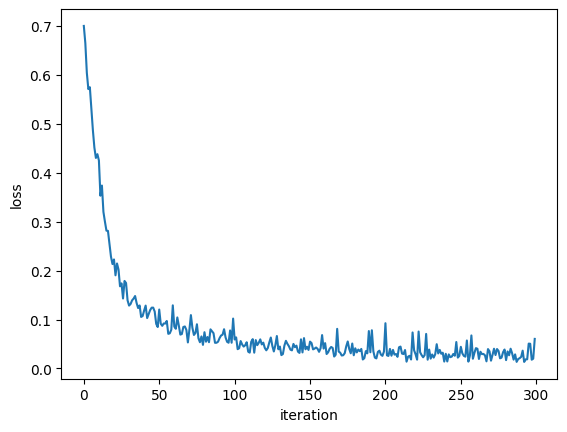

In [25]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [47]:
misclassified_samples = []
missclassified_id = 0
for x_test, y_test in validation_loader:
    model.eval()
    # with torch.no_grad():
    yhat = model(x_test)
    _, predicted = torch.max(yhat.data, 1)
    for i in range(len(predicted)):
        if predicted[i] != y_test[i]:
            misclassified_samples.append((missclassified_id, y_test[i], predicted[i]))
            if len(misclassified_samples) == 4:
                break
        missclassified_id = missclassified_id + 1
    if len(misclassified_samples) == 4:
        break

C:\Users\admin\AppData\Local\Temp\ipykernel_11020\794545735.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(self.all_files[idx]) # Load the image from 

In [48]:
print("First four misclassified samples:")
for i, (id, y_true, y_pred) in enumerate(misclassified_samples):
    print(f"Sample {id+1} predicted value: {y_pred.item()}  actual value:{y_true.item()}")


First four misclassified samples:
Sample 23 predicted value: 0  actual value:1
Sample 102 predicted value: 1  actual value:0
Sample 183 predicted value: 0  actual value:1
Sample 214 predicted value: 1  actual value:0


<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_source=Exinfluencer&utm_content=000026UJ&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01&utm_medium=Exinfluencer&utm_term=10006555"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
